In [10]:
%pip install -U ddgs

  Using cached lxml-6.0.2-cp311-cp311-win_amd64.whl.metadata (3.7 kB)
  Using cached fake_useragent-2.2.0-py3-none-any.whl.metadata (17 kB)
  Using cached brotli-1.2.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached h2-4.3.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached socksio-1.0.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached hyperframe-6.1.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached hpack-4.1.0-py3-none-any.whl.metadata (4.6 kB)
   ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
   ---------- ----------------------------- 10.2/40.3 kB ? eta -:--:--
   -------------------- ------------------- 20.5/40.3 kB 222.6 kB/s eta 0:00:01
   ---------------------------------------- 40.3/40.3 kB 323.3 kB/s eta 0:00:00
Using cached fake_useragent-2.2.0-py3-none-any.whl (161 kB)
Using cached socksio-1.0.0-py3-none-any.whl (12 kB)
Using cached lxml-6.0.2-cp311-cp311-win_amd64.whl (4.0 MB)
   ---------------------------------------- 0.0/3.5 MB ? eta -:-


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: C:\Users\nages\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph.message import add_messages


from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

import requests
import random

In [12]:
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI()

In [13]:
#tools
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num: float, seconf_num: float, operation: str) -> float:
    """
    performs basic arithmetic operations (addition, subtraction, multiplication, division) on two numbers.
    Parameters:
    - first_num: The first number for the calculation.
    - seconf_num: The second number for the calculation.
    - operation: A string indicating the operation to perform ("add", "subtract", "multiply", "divide").
    Returns:
    - The result of the arithmetic operation.
    """
    try:
        if operation == "add":
            return first_num + seconf_num
        elif operation == "subtract":
            return first_num - seconf_num
        elif operation == "multiply":
            return first_num * seconf_num
        elif operation == "divide":
            if seconf_num == 0:
                raise ValueError("Cannot divide by zero")
            return first_num / seconf_num
        else:
            raise ValueError("Invalid operation")
        return {"first_num": first_num, "second_num": seconf_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}
    

@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stovk proce for a given symbol (e.g: 'AAPL', 'TSLA')
    using alpha vantage with API key in the url.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9PE94QUEW9VWGFM"
    r = requests
    return r.json()

In [15]:
tools = [get_stock_price, calculator, search_tool]

llm_with_tools = llm.bind_tools(tools)

In [18]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

def chat_node(state: ChatState):
    response = llm_with_tools.invoke(state['messages'])
    return {'messages': [response]}

tools_node = ToolNode(tools)

In [19]:
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tools_node)

In [20]:
graph.add_edge(START, "chat_node")

graph.add_conditional_edges("chat_node", tools_condition)

In [21]:
chatbot = graph.compile()

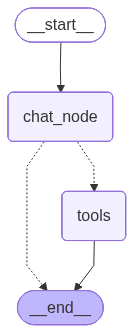

In [22]:
chatbot

In [23]:
output = chatbot.invoke({"messages":[HumanMessage(content="hello!")]})
print(output["messages"][-1].content)

Hello! How can I assist you today?


In [24]:
prompt = "what is the addition of 56+658+65?"
output = chatbot.invoke({"messages":[HumanMessage(content=prompt)]})
print(output["messages"][-1].content)

714.0


In [26]:
prompt = "what is the stock price of AAPL and what is 23 multiplied by 45?"
output = chatbot.invoke({"messages":[HumanMessage(content=prompt)]})
print(output)

{'messages': [HumanMessage(content='what is the stock price of AAPL and what is 23 multiplied by 45?', additional_kwargs={}, response_metadata={}, id='37f1074e-55c0-4f78-b5e7-a75535c9815c'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 252, 'total_tokens': 308, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-DAF71ePxNEwoyo5rFxnw38aPUMMjD', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c6bb6-02ea-71b3-afea-5837a4232555-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'AAPL'}, 'id': 'call_7KfHtrie1t52vEdChGkRpB7U', 'type': 'tool_call'}, {'name': 'calculator', 'args': {'first_num